# Rotation speed of a single dimer

In [1]:
import lammps2d as lmp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anm
import matplotlib.collections as clt
import pandas as pd
import string as st
import scipy.spatial as spp
import scipy.optimize as spo

from IPython.display import HTML

%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Sample rotation of a single dimer

In [2]:
radius = 1.4 #um
angle = 27 #degrees

height = 5
frequency = 10
region = [100,100,height]

sigma = 2*radius
y = 1/2*np.sqrt(sigma**2-(sigma-height)**2)
z = 1/2*(sigma-height)
initial_positions = np.array([[0,-y,-z],[0,y,z]])

sim = lmp.sim(initial_positions,
          magnitude = 7.28,
          file_name = "single_dimer_rotation",
          dir_name = "SingleD",
          radius = radius,
          diffusion = 0.14,
          frequency=frequency,
          susceptibility = 0.4,
          angle=angle,
          framerate=7e1,
          timestep=1e-4,
          total_time = 10,
          temperature = 300,
          stamp_time = False,
          lj_parameters = [1e-2,1/(2**(1/6))],
          space = {'region':region,'boundary':['s','s','f'],'walls':[False,False,True]})

sim.generate_scripts()
sim.run()

trj = sim.load(read_trj=True)
dim = lmp.dimers(trj,sim,2.9)

In [3]:
HTML(lmp.display_animation_direct(sim))

In [4]:
def calculate_dimer_angular_velocity(dim):
    """ This is a quick ad hoc function to calculate the dimer angular velocity. 
    It is designed for only one dimer. For more dimer I should do a smarter use of the relationship between 
    dimer frames and particle frames in order to calculate things vectorially."""
    
    idx = pd.IndexSlice
    dim.loc[:,'x']=1
    dim.loc[:,'y']=1
    dim.loc[:,'z']=1

    dim.loc[:,'dx']=1
    dim.loc[:,'dy']=1
    dim.loc[:,'dz']=1

    dim['time'] = dim.index.get_level_values('frame')*sim.run_parameters.timestep

    for f in dim.index.get_level_values('frame').values:
        members = list(dim.loc[idx[f,0]]['members']);
        p0 = trj.loc[idx[f,members[0]]].filter(('x','y','z')).values
        p1 = trj.loc[idx[f,members[1]]].filter(('x','y','z')).values
        dim.loc[idx[f,0],('x','y','z')] = (p0+p1)/2
        dim.loc[idx[f,0],('dx','dy','dz')] = (p0-p1)/2
        time = dim.time
        
    angle = np.unwrap(np.arctan2(dim.dx,dim.dy).values)

    omega = np.diff(angle)/np.diff(time)
    return np.mean(omega[time[0:-1]>0.5]) # Here I get rid of any initial transient 
calculate_dimer_angular_velocity(dim)

62.834173915449135

In [5]:
def calculate_pair_angular_velocity(trj,sim):
    """ 
    This is a simpler function which doesn't require pair identification. 
    It needs trj to only contain two particles and it calculates the angular velocity of these.
    """
    
    ids = trj.index.get_level_values('id').unique()
    
    if np.size(trj.index.get_level_values('id').unique())!=2:
        raise ValueError("This function only accepts two particles")
        
    idx = pd.IndexSlice
    frames = trj.index.get_level_values('frame').unique()
    time = trj.index.get_level_values('frame').unique().values*sim.run_parameters.timestep
    angle = np.empty(np.shape(time))
    
    for i,f in enumerate(frames):
        
        delta = (trj.loc[idx[f,ids[0]]].filter(('x','y','z')).values - 
                 trj.loc[idx[f,ids[1]]].filter(('x','y','z')).values)/2
        
        angle[i] =  np.arctan2(delta[0],delta[1])
    
    angle = np.unwrap(angle)
    omega = np.diff(angle)/np.diff(time)
    return np.mean(omega[time[0:-1]>0.5])

calculate_pair_angular_velocity(trj,sim)

62.834173915449135

# Synchronous - Asynchronous transition

In [6]:
%%time 

radius = 1.4 #um
angle = 27 #degrees

height = 5

frequency = np.arange(0,50,2)+2
rel_freq = np.nan*np.ones(np.shape(frequency))

region = [100,100,height]

sigma = 2*radius
y = 1/2*np.sqrt(sigma**2-(sigma-height)**2)
z = 1/2*(sigma-height)
initial_positions = np.array([[0,-y,-z],[0,y,z]])

for i,f in enumerate(frequency):
    sim = lmp.sim(initial_positions,
              magnitude = 7.28,
              file_name = "single_dimer_rotation",
              dir_name = "SingleD",
              radius = radius,
              diffusion = 0.14,
              frequency=f,
              susceptibility = 0.4,
              angle=angle,
              framerate=1e3,
              timestep=1e-4,
              total_time = 5,
              temperature = 300,
              stamp_time = False,
              lj_parameters = [1e-2,1/(2**(1/6))],
              space = {'region':region,'boundary':['s','s','f'],'walls':[False,False,True]})

    sim.generate_scripts()
    sim.run()

    trj = sim.load(read_trj=True)

    rel_freq[i] = calculate_pair_angular_velocity(trj,sim)/(2*np.pi*f)

Wall time: 8min 53s


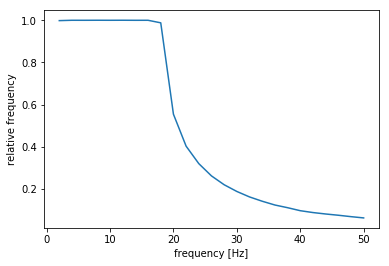

In [7]:
plt.plot(frequency,rel_freq)
plt.xlabel('frequency [Hz]')
plt.ylabel('relative frequency')

## What function can I fit it with?

### Adler Function

$$ f_{rel} = 
\begin{cases}
1 & f\leq f_c \\
1-\sqrt{1-\left(\frac{f_c}{f}\right)^2} & f>f_c
\end{cases}$$

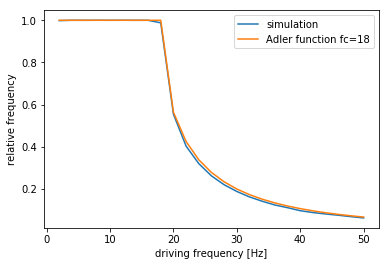

In [8]:
def rel_freq_fun(f,fc):
    rel_freq = np.empty(np.shape(f))
    rel_freq[f<=fc] = 1
    rel_freq[f>fc] = 1-np.sqrt(1-(fc/f[f>fc])**2)
    return rel_freq

plt.plot(frequency,np.vstack((rel_freq,rel_freq_fun(frequency,18))).transpose())
plt.xlabel('driving frequency [Hz]')
plt.ylabel('relative frequency')
plt.legend(['simulation','Adler function fc=18']);

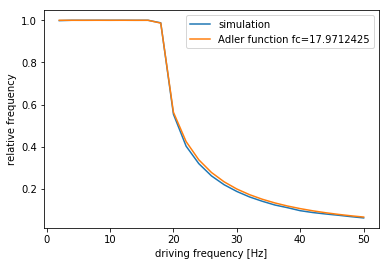

In [9]:
fc = spo.curve_fit(rel_freq_fun,frequency,rel_freq)[0][0]

plt.plot(frequency,np.vstack((rel_freq,rel_freq_fun(frequency,fc))).transpose())
plt.xlabel('driving frequency [Hz]')
plt.ylabel('relative frequency')
plt.legend(['simulation','Adler function fc=17.9712425']);

## How does it work with a smaller height?

In [10]:
radius = 1.4 #um
angle = 27 #degrees

height = 4.8

frequency = np.arange(0,40,4)+4
rel_freq = np.nan*np.ones(np.shape(frequency))

region = [100,100,height]

sigma = 2*radius
y = 1/2*np.sqrt(sigma**2-(sigma-height)**2)
z = 1/2*(sigma-height)
initial_positions = np.array([[0,-y,-z],[0,y,z]])

for i,f in enumerate(frequency):
    sim = lmp.sim(initial_positions,
              magnitude = 7.28,
              file_name = "single_dimer_rotation",
              dir_name = "SingleD",
              radius = radius,
              diffusion = 0.14,
              frequency=f,
              susceptibility = 0.4,
              angle=angle,
              framerate=1e3,
              timestep=1e-4,
              total_time = 5,
              temperature = 300,
              stamp_time = False,
              lj_parameters = [1e-2,1/(2**(1/6))],
              space = {'region':region,'boundary':['s','s','f'],'walls':[False,False,True]})

    sim.generate_scripts()
    sim.run()

    trj = sim.load(read_trj=True)

    rel_freq[i] = calculate_pair_angular_velocity(trj,sim)/(2*np.pi*f)

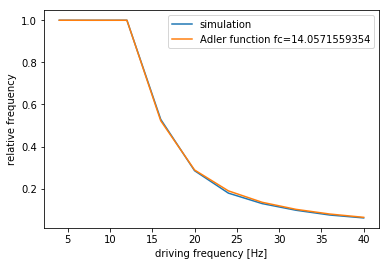

In [11]:
fc = spo.curve_fit(rel_freq_fun,frequency,rel_freq)[0][0]

plt.plot(frequency,np.vstack((rel_freq,rel_freq_fun(frequency,fc))).transpose())
plt.xlabel('driving frequency [Hz]')
plt.ylabel('relative frequency')
plt.legend(['simulation','Adler function fc='+str(fc)]);

# Frequency cutoff as a function of height

In [15]:
%%time
height = np.linspace(4.8,5.6,50)
radius = 1.4 #um
angle = 27 #degrees
frequency = np.arange(0,200,8)+8
rel_freq = np.empty(np.shape(frequency))

cutoff_frequency = np.nan*np.ones(np.shape(height))

response = []

for j,h in enumerate(height):
    
    region = [100,100,h]
    sigma = 2*radius
    y = 1/2*np.sqrt(sigma**2-(sigma-h)**2)
    z = 1/2*(sigma-h)
    initial_positions = np.array([[0,-y,-z],[0,y,z]])
    
    for i,f in enumerate(frequency):
        sim = lmp.sim(initial_positions,
                      magnitude = 7.28,
                      file_name = "single_dimer_rotation_f%g"%f,
                      dir_name = "SingleD/h_%g"%h,
                      radius = radius,
                      diffusion = 0.14,
                      frequency=f,
                      susceptibility = 0.4,
                      angle=angle,
                      framerate=1e3,
                      timestep=1e-4,
                      total_time = 2,
                      temperature = 300,
                      stamp_time = False,
                      lj_parameters = [1e-2,1/(2**(1/6))],
                      space = {'region':region,'boundary':['s','s','f'],'walls':[False,False,True]})

        sim.generate_scripts()
        sim.run()
        trj = sim.load(read_trj=True)
        
        if trj.index.get_level_values('frame').max()<sim.run_parameters.total_time/sim.run_parameters.timestep:
            sim.field_parameters.lj_parameters = [0.5e-2,1/(2**(1/6))] 
            sim.generate_scripts()
            sim.run()
            trj = sim.load(read_trj=True)
            
        try:
            rel_freq[i] = calculate_pair_angular_velocity(trj,sim)/(2*np.pi*f)
        except:
            rel_freq[i] = np.nan
    
    res = pd.DataFrame({'response':rel_freq},index=frequency)
    res.index.name='frequency'
    res.to_csv(path_or_buf=sim.base_name+'.dat',sep="\t")
    
    response.append(res)
    
    try:
        rel_freq_fit = rel_freq[~np.isnan(rel_freq)]
        frequency_fit = frequency[~np.isnan(rel_freq)]
        cutoff_frequency[j] = spo.curve_fit(rel_freq_fun,frequency_fit,rel_freq_fit)[0][0]
    except:
        cutoff_frequency[j]=np.nan
    

C:\ProgramFiles\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramFiles\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramFiles\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Wall time: 2h 24min 52s


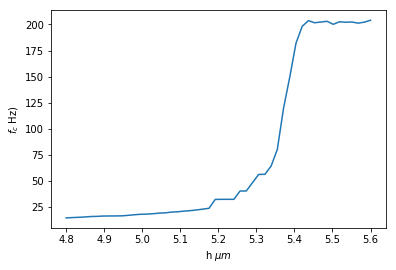

In [37]:
plt.plot(height,cutoff_frequency)
plt.xlabel("h $\mu{m}$")
plt.ylabel("$f_c$ Hz")

(0, 50)

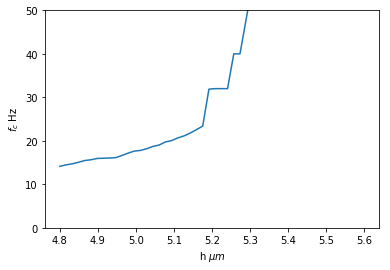

In [38]:
plt.plot(height,cutoff_frequency)
plt.xlabel("h $\mu{m}$")
plt.ylabel("$f_c$ Hz")
plt.ylim(0,50)

This is puzzling. This is a very fast rotational speed.

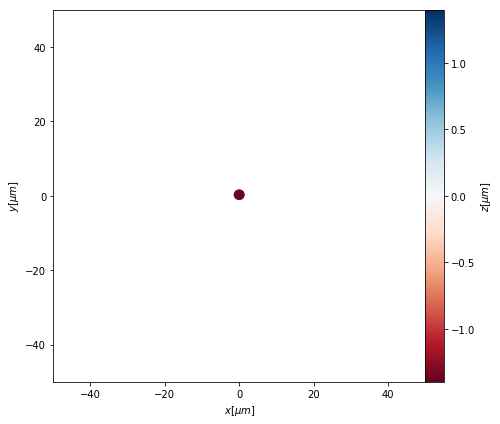

In [23]:
lmp.draw_trj(trj,sim)

It seems that particles are almost on top of each other. Maybe I can plot the critical frequency as a function of observed rotation angle for different driving frequencies.

## Different conditions for low confinement

In the previous trial, when the system was unstable, I would make slightly softer particles to improve stability. It appears that this softness allows particles to jump on top of each other more easily.

I will try to keep the particle potential constant, and instead try a smaller timestep for those unstable points. 

In [39]:
%%time
height = np.linspace(4.8,5.6,50)
radius = 1.4 #um
angle = 27 #degrees
frequency = np.arange(0,200,8)+8
rel_freq = np.empty(np.shape(frequency))

cutoff_frequency = np.nan*np.ones(np.shape(height))

response = []

for j,h in enumerate(height):
    
    region = [100,100,h]
    sigma = 2*radius
    y = 1/2*np.sqrt(sigma**2-(sigma-h)**2)
    z = 1/2*(sigma-h)
    initial_positions = np.array([[0,-y,-z],[0,y,z]])
    
    for i,f in enumerate(frequency):
        sim = lmp.sim(initial_positions,
                      magnitude = 7.28,
                      file_name = "single_dimer_rotation_f%g"%f,
                      dir_name = "SingleD/h_%g"%h,
                      radius = radius,
                      diffusion = 0.14,
                      frequency=f,
                      susceptibility = 0.4,
                      angle=angle,
                      framerate=1e3,
                      timestep=1e-4,
                      total_time = 2,
                      temperature = 300,
                      stamp_time = False,
                      lj_parameters = [1e-2,1/(2**(1/6))],
                      space = {'region':region,'boundary':['s','s','f'],'walls':[False,False,True]})

        sim.generate_scripts()
        sim.run()
        trj = sim.load(read_trj=True)
        
        if trj.index.get_level_values('frame').max()<sim.run_parameters.total_time/sim.run_parameters.timestep:
            sim.run_parameters.timestep = sim.run_parameters.timestep/2
            sim.generate_scripts()
            sim.run()
            trj = sim.load(read_trj=True)
            
        try:
            rel_freq[i] = calculate_pair_angular_velocity(trj,sim)/(2*np.pi*f)
        except:
            rel_freq[i] = np.nan
    
    res = pd.DataFrame({'response':rel_freq},index=frequency)
    res.index.name='frequency'
    res.to_csv(path_or_buf=sim.base_name+'.dat',sep="\t")
    
    response.append(res)
    
    try:
        rel_freq_fit = rel_freq[~np.isnan(rel_freq)]
        frequency_fit = frequency[~np.isnan(rel_freq)]
        cutoff_frequency[j] = spo.curve_fit(rel_freq_fun,frequency_fit,rel_freq_fit)[0][0]
    except:
        cutoff_frequency[j]=np.nan
    

C:\ProgramFiles\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramFiles\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramFiles\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Wall time: 2h 44min 46s


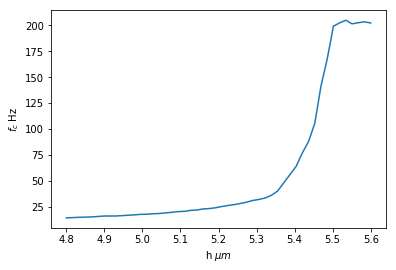

In [41]:
plt.plot(height,cutoff_frequency)
plt.xlabel("h $\mu{m}$")
plt.ylabel("$f_c$ Hz")

(0, 1.3)

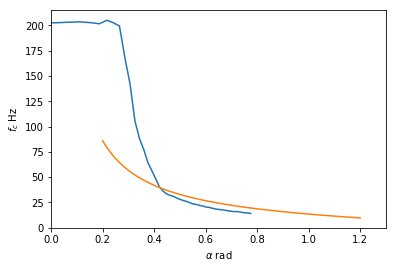

In [71]:
alpha = np.arccos((height-sigma)/sigma)
plt.plot(alpha,cutoff_frequency)

alpha_expr = np.linspace(0.2,1.2,100)
theta = 27/180*np.pi
delta = np.arccos(1/4*np.sqrt((np.tan(alpha_expr)*np.tan(theta))**(-2)+8)-1/(4*np.tan(alpha_expr)*np.tan(theta)))

sa = np.sin(alpha_expr)
st = np.sin(theta)
sd = np.sin(delta)
ca = np.cos(alpha_expr)
ct = np.cos(theta)
cd = np.cos(delta)

f0 = 14.3*3
fc_expr = f0*st/sa*sd*(sa*st*cd+ca*ct)
plt.plot(alpha_expr,fc_expr)

plt.xlabel("$\\alpha$ rad")
plt.ylabel("$f_c$ Hz")
#plt.ylim(0,50)
plt.xlim(0,1.3)